# Differential Privacy for ML Course - Lab #1

*Master IASD, PSL - O. Cappé, January 2024*

This first lab is intended to perform basic experiments regarding attacks.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [ ]:
# Load data from the Pima Indians dataset
# Use data from https://openml.org/search?type=data&status=active&id=37
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the data from a CSV file
# Replace 'diabetes.csv' with the path to your actual file
csv_file = '/content/diabetes.csv'
pima = pd.read_csv(csv_file)

# Assuming the target column is 'Outcome' and its values are 1 for positive and 0 for negative
# Modify these names/values if your dataset differs
target_column = 'Outcome'
positive_label = 1  # Replace with the actual positive label in your CSV
negative_label = 0  # Replace with the actual negative label in your CSV

# Convert the target to numeric +/- 1
outcome = np.where(pima[target_column] == positive_label, 1, -1)

# Get the number of samples
n = outcome.size

# Print class probabilities
print('Class probabilities: {0:.2f}, {1:.2f}'.format(np.sum(outcome == -1) / n, np.sum(outcome == 1) / n))

# Extract features and standardize them
# Assuming the features are all columns except the target column
features = pima.drop(columns=[target_column]).values

# Standardize the features and add an intercept column
data = np.concatenate((np.ones((n, 1)), StandardScaler().fit_transform(features)), axis=1)

# Output the shape of the final dataset
print(f'Data shape: {data.shape}')


Class probabilities: 0.65, 0.35
Data shape: (768, 9)


# L1.1 Warm-Up: Recovery of Binary Answers from Random Projections

- Complete the code below with your idea of how to predict the labels <code>y</code> from the observed random dot products <code>z</code> (assuming that the matrix <code>W</code> is known) an observe the ROC and DET curves.
- By varying <code>p</code>, find the minimal value of <code>p</code> that give non trivial recovery performance? For what value of <code>p</code> can you recover 50% of the labels at 5% FPR?
- What changes if we now assume that some of the labels in <code>y</code> are known?

we assume that we know z and W--> what is the value of Y. However this is not obvious because if the matrix w was squared and invertible we would just need this for one solution. In our case this is not true.
p<n  the number of features is less than parameters. So it is not possible to find Y exactly.

Predict Y that is dependent on a treshold.

use ridge regression with min ||z-Wy||² + lambda||Y||² and compute the gradient. So that Y = (wTw +lambda)⁻¹wTz

When lambda tends to 0 we end up in a situation of pseudo inverse where we want to min ||Y||² st z=Wy.The solution y = W^#z

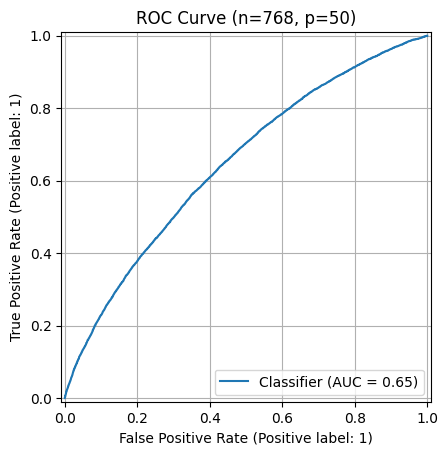

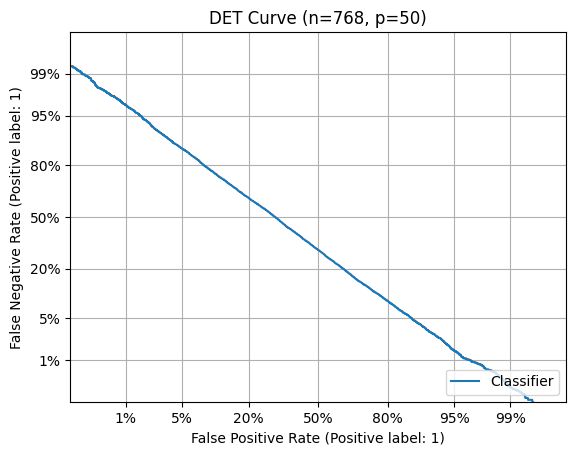

In [ ]:
# Use label mapped to {-1,1}
y = outcome
n = y.size
# Observe p dot products with random sign vectors
p = 50
# Do it several times to get statistically significant results
nMC = 50    # Number of Monte Carlo runs
estim = np.zeros((nMC, n))
for iMC in range (nMC):
    # Observe dot product with random signs matrix
    W = np.power(-1, np.random.binomial(1, 0.5, size=(p,n)))
    z = np.matmul(W, y)
    # Begin TODO: Use a better estimation method!
    estim[iMC, :] = np.matmul(np.linalg.pinv(W),z)
    # End TODO
# Plot ROC (Receiver Operating Characteristic) and DET (Detection Error Tradeoff) curves
metrics.RocCurveDisplay.from_predictions(np.tile(y, nMC), np.reshape(estim,nMC*n))
plt.title("ROC Curve (n={}, p={})".format(n, p))
plt.grid(True)
plt.show()
metrics.DetCurveDisplay.from_predictions(np.tile(y, nMC), np.reshape(estim,nMC*n))
plt.title("DET Curve (n={}, p={})".format(n, p))
plt.grid(True)
plt.show()

When you also apply Ridge regression you obtain similar results.So on average for p = 50 we can recover information about 30 people. When increasing p we should be more successful.

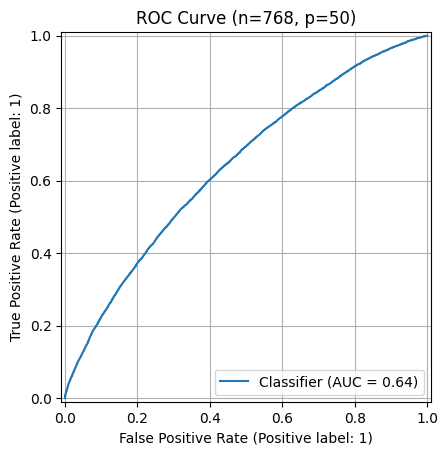

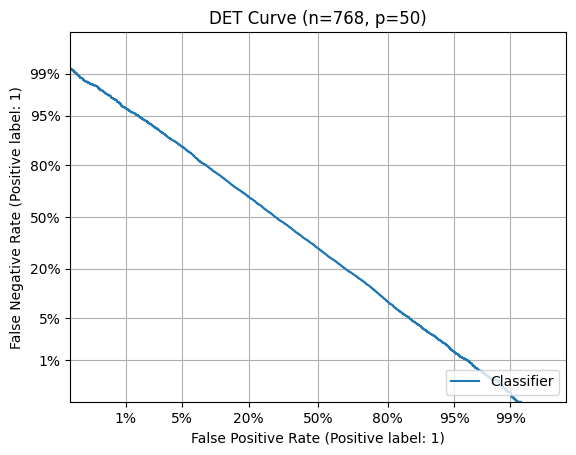

In [ ]:
# Use label mapped to {-1,1}
y = outcome
n = y.size
# Observe p dot products with random sign vectors
p = 50
# Do it several times to get statistically significant results
nMC = 50    # Number of Monte Carlo runs
estim = np.zeros((nMC, n))

lambda_reg = 0.05

for iMC in range (nMC):
    # Observe dot product with random signs matrix
    W = np.power(-1, np.random.binomial(1, 0.5, size=(p,n)))
    z = np.matmul(W, y)
    WTW = W.T @ W
    regularized_inverse = np.linalg.inv(WTW + lambda_reg * np.eye(n))
    W_pseudo = regularized_inverse @ W.T
    estim[iMC, :] = W_pseudo @ z  # Estimate y

# Flatten estimated values for ROC and DET plotting
flattened_estim = np.reshape(estim, nMC * n)
flattened_y = np.tile(y, nMC)
# Plot ROC (Receiver Operating Characteristic) and DET (Detection Error Tradeoff) curves
metrics.RocCurveDisplay.from_predictions(np.tile(y, nMC), np.reshape(estim,nMC*n))
plt.title("ROC Curve (n={}, p={})".format(n, p))
plt.grid(True)
plt.show()
metrics.DetCurveDisplay.from_predictions(np.tile(y, nMC), np.reshape(estim,nMC*n))
plt.title("DET Curve (n={}, p={})".format(n, p))
plt.grid(True)
plt.show()

In [ ]:
# Use label mapped to {-1,1}
y = outcome
n = y.size
auc_dict = {}
# Observe p dot products with random sign vectors
for p in range(10, 300, 10):  # Start from 10 to avoid invalid matrix sizes
    nMC = 50  # Number of Monte Carlo runs
    estim = np.zeros((nMC, n))

    for iMC in range(nMC):
        # Observe dot product with random signs matrix
        W = np.power(-1, np.random.binomial(1, 0.5, size=(p, n)))
        z = np.matmul(W, y)

        # Use a better estimation method (for now, pseudoinverse)
        estim[iMC, :] = np.matmul(np.linalg.pinv(W), z)

    # Compute ROC Curve
    fpr, tpr, _ = metrics.roc_curve(np.tile(y, nMC), np.reshape(estim, nMC * n))
    auc_score = metrics.auc(fpr, tpr)

    # Store AUC score
    auc_dict[p] = auc_score


In [ ]:
print(auc_dict)

{10: 0.5652401850746269, 20: 0.5916343731343284, 30: 0.6122488597014926, 40: 0.6271341432835822, 50: 0.6453270298507463, 60: 0.6620627880597014, 70: 0.6752021432835821, 80: 0.6874238985074628, 90: 0.6971951164179104, 100: 0.7082854985074627, 110: 0.7204974388059702, 120: 0.729448023880597, 130: 0.7375463731343284, 140: 0.7476560388059701, 150: 0.7531866626865671, 160: 0.7665858029850746, 170: 0.7719924298507463, 180: 0.7821639283582089, 190: 0.7905443910447761, 200: 0.7992834507462686, 210: 0.8091636447761195, 220: 0.8130118447761194, 230: 0.8213733910447761, 240: 0.8306806417910447, 250: 0.8390182746268657, 260: 0.8446380597014925, 270: 0.8474927671641791, 280: 0.8549637791044775, 290: 0.8606450865671642}


For p =10 we already get a non trivial classifier, but the higher p is the better the AUC

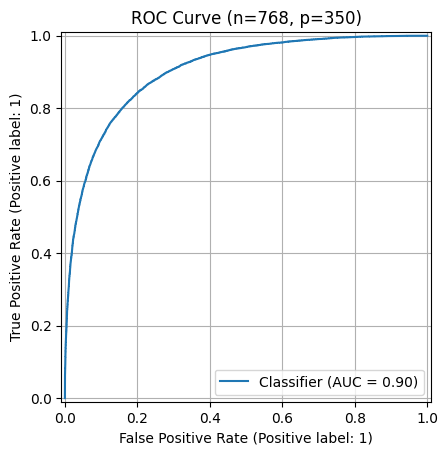

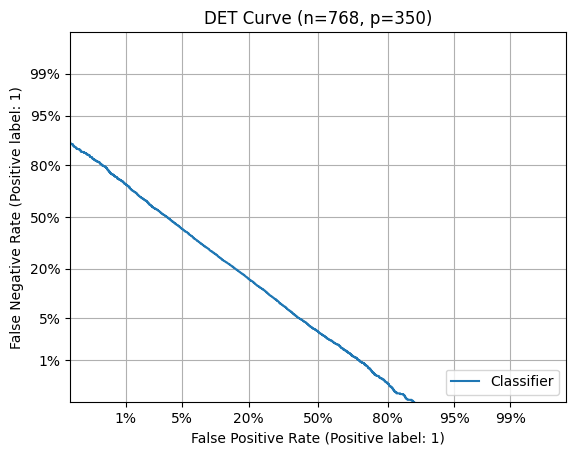

In [ ]:
# Use label mapped to {-1,1}
y = outcome
n = y.size
# Observe p dot products with random sign vectors
p = 350
# Do it several times to get statistically significant results
nMC = 50    # Number of Monte Carlo runs
estim = np.zeros((nMC, n))
for iMC in range (nMC):
    # Observe dot product with random signs matrix
    W = np.power(-1, np.random.binomial(1, 0.5, size=(p,n)))
    z = np.matmul(W, y)
    # Begin TODO: Use a better estimation method!
    estim[iMC, :] = np.matmul(np.linalg.pinv(W),z)
    # End TODO
# Plot ROC (Receiver Operating Characteristic) and DET (Detection Error Tradeoff) curves
metrics.RocCurveDisplay.from_predictions(np.tile(y, nMC), np.reshape(estim,nMC*n))
plt.title("ROC Curve (n={}, p={})".format(n, p))
plt.grid(True)
plt.show()
metrics.DetCurveDisplay.from_predictions(np.tile(y, nMC), np.reshape(estim,nMC*n))
plt.title("DET Curve (n={}, p={})".format(n, p))
plt.grid(True)
plt.show()

It seems around p =350 we get can  recover 50% of the labels at 5% FPR.



Knowing the labels would allow us to get more accurate results and simplify the problem.

## Logistic Regression

In this part, we provide a utility function that can be used to compare two ROC curves on the same plot and examine the result of using logistic regression on this dataset (you can experiment with different train and test splits).

In [ ]:
def display_two_roc_curves_from_predictions(y_true1, y_score1, label1, y_true2, y_score2, label2):
    """
    Plots two ROC curves from given true labels and predicted scores.

    Parameters:
    y_true1 (array-like): True binary labels for the first set of predictions.
    y_score1 (array-like): Target scores for the first set of predictions.
    label1 (str): Label for the first ROC curve.
    y_true2 (array-like): True binary labels for the second set of predictions.
    y_score2 (array-like): Target scores for the second set of predictions.
    label2 (str): Label for the second ROC curve.
    """
    fpr1, tpr1, tresh = metrics.roc_curve(y_true1, y_score1)
    auc1 = metrics.roc_auc_score(y_true1, y_score1)
    plt.plot(fpr1, tpr1, label=label1+' (AUC={0:.2f})'.format(auc1))
    fpr2, tpr2, tresh = metrics.roc_curve(y_true2, y_score2)
    auc2 = metrics.roc_auc_score(y_true2, y_score2)
    plt.plot(fpr2, tpr2, label=label2+' (AUC={0:.2f})'.format(auc2))
    plt.legend(loc=0)
    plt.grid(True)
    plt.xlabel('FPR')
    plt.ylabel('TPR')

Training and test accuracies: 0.82, 0.78


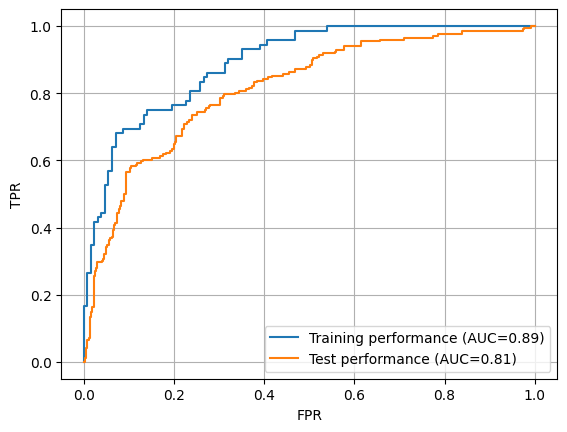

In [ ]:
# Fit logistic regression to the data (without intercept as we explicitly added it to the data already)
X = data
y = outcome
(n, d) = X.shape
n_train = 200
n_test = n - n_train
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n_train, random_state=45)
logreg = LogisticRegression(fit_intercept=False)
logreg.fit(X_train, y_train)
# Plot training and test performance as ROCs
y_train_pred = logreg.predict_proba(X_train)[:,1]
y_test_pred = logreg.predict_proba(X_test)[:,1]
print('Training and test accuracies: {0:.2f}, {1:.2f}'.format(np.sum(y_train*(y_train_pred-0.5) > 0)/n_train,
    np.sum(y_test*(y_test_pred-0.5) > 0)/n_test))
display_two_roc_curves_from_predictions(y_train, y_train_pred, 'Training performance',
    y_test, y_test_pred, 'Test performance')
plt.show()

## L1.2 Model Inversion Attack




- Write a function that computes the gradients of the logistic loss for all the training points <code>(X,y)</code>.
- Use these to construct a test statistic that can be used to guess the value of an unknown data point in <code>y</code> given <code>p</code> other ones, which are assumed to be known (<code>X</code> as well as the fitted model <code>logreg</code> are also assumed to be known).
- Experimenting with random subsets of the data (using the provided code as example), for what values of <code>p</code> does this approach start to give non trivial recovery performance?
- Try different values of the training size <code>n</code>; how does it modify the previous conclusion? What aspect of the model appears to be important for ensuring the success of the recovery?

Not use test. Go back to training and want to Y given the value of the fited model (logreg).

We have lables (X1...Xn;Y1,...Yn)
we knwow θ and all the labels except 1, so [θ, X1,...Xn; {Yj} ] how do we find the missing one.
This method can be extended similarly to the pseudo-inverse with p very close to n.

In [ ]:

def logreg_gradients(X, y, logreg):
    """
    Compute the gradients of the logistic regression loss function with respect to model parameters.

    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n, d), where n is the number of samples and d is the number of features.
    y (numpy.ndarray): Target labels of shape (n,), where n is the number of samples.
    logreg (object): A trained logistic regression model.

    Returns:
    numpy.ndarray: The gradient matrix of shape (n, d), where each row corresponds to the gradient for a single sample.
    """
    n, d = X.shape
    p_hat = logreg.predict_proba(X)[:, 1]  # Predicted probabilities
    gradients = np.zeros((n, d))  # Initialize gradient matrix

    for i in range(n):
        gradients[i, :] = X[i, :] * (p_hat[i] - y[i])  # Compute gradient for each sample

    return gradients


Assume known labels are equal to p. Find p+1 randomindex from the training set and recostruct the first one with the other. Very bad when p is very small compared to n. (p=195). The model does something that is not trivial. (look at prediction of Xi)

Compute gradient of logistic regression, and what does sklearn do when training the logisitic regression

min average training loss and invert this condition

Y compatible with condition on gradient. 1 obs missing

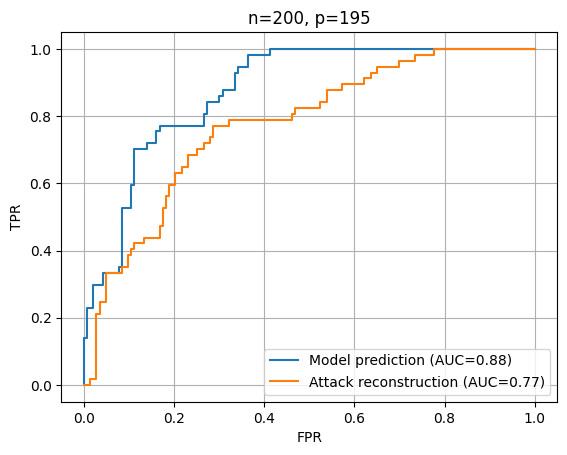

In [ ]:
# We will work on recovering data from the training sample
X = X_train
y = y_train
(n, d) = X.shape
# Compute the probabilistic predictions from the model
p_hat = logreg.predict_proba(X)[:,1]
# Try reconstruction attack assuming p known labels on randomly chosen data subsets
p =195  # Number of known labels
# Number of Monte Carlo experiments
nMC = 200
y_true = np.zeros(nMC)
y_guess = np.zeros(nMC)
y_pred = np.zeros(nMC)

grads = logreg_gradients(X_train, y_train, logreg)

for i in range(nMC):
        ind = np.random.permutation(len(X_train))
        y_true[i] = y_train[ind[0]]
        y_pred[i] = p_hat[ind[0]]

        known_grad = np.sum(grads[ind[1:p+1]], axis=0)

        g1 = X_train[ind[0]] * (p_hat[ind[0]] - 1)
        g0 = X_train[ind[0]] * p_hat[ind[0]]

        s1 = known_grad + g1
        s0 = known_grad + g0

        y_guess[i] = 0.5 * ((np.sum(np.square(s1))) - np.sum(np.square(s0)))

    # End TODO
display_two_roc_curves_from_predictions(y_true, y_pred, 'Model prediction',
    y_true, y_guess, 'Attack reconstruction')
plt.title("n={}, p={}".format(n, p))
plt.show()

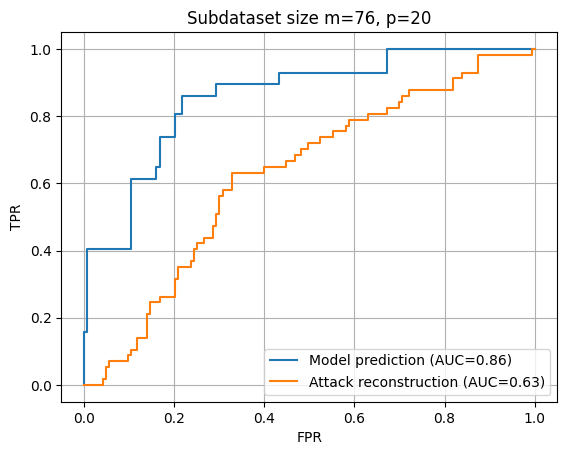

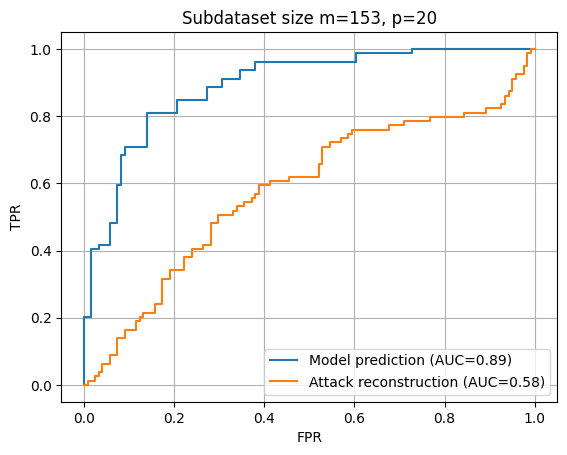

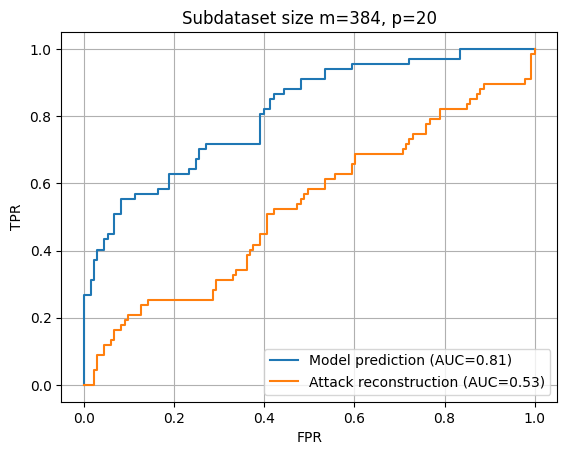

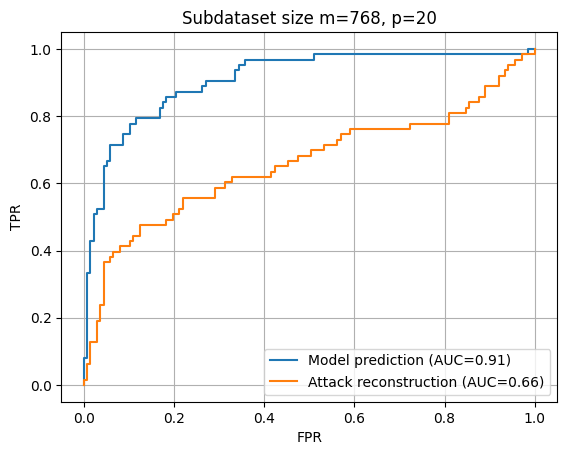

In [ ]:

def experiment_with_subdatasets(subdataset_sizes):
    p = 20

    for m in subdataset_sizes:

        # Randomly select a subset of size m from the full dataset
        indices = np.random.choice(len(data), m, replace=False)
        X_subset = data[indices]
        y_subset = outcome[indices]

        # Train a logistic regression model on the subset
        logreg = LogisticRegression()
        logreg.fit(X_subset, y_subset)

        # Compute predicted probabilities on the subset
        p_hat = logreg.predict_proba(X_subset)[:, 1]

        # Calculate gradients for each sample in the subset
        grads = logreg_gradients(X_subset, y_subset, logreg)

        # Run the attack for this subdataset size
        y_true = np.zeros(nMC)
        y_pred = np.zeros(nMC)
        y_guess = np.zeros(nMC)

        for i in range(nMC):
            ind = np.random.permutation(len(X_subset))
            y_true[i] = y_subset[ind[0]]
            y_pred[i] = p_hat[ind[0]]

            # Known gradient information
            known_grad = np.sum(grads[ind[1:p+1]], axis=0)

            g1 = X_subset[ind[0]] * (p_hat[ind[0]] - 1)
            g0 = X_subset[ind[0]] * p_hat[ind[0]]

            s1 = known_grad + g1
            s0 = known_grad + g0

            y_guess[i] = 0.5 * ((np.sum(np.square(s1))) - np.sum(np.square(s0)))

        # Plot ROC curves for each subdataset size
        display_two_roc_curves_from_predictions(
            y_true, y_pred, 'Model prediction', y_true, y_guess, 'Attack reconstruction'
        )
        plt.title(f"Subdataset size m={m}, p={p}")
        plt.show()

# Define a range of subdataset sizes to test (e.g., 10%, 20%, 50%, 100% of the dataset)
subdataset_sizes = [int(0.1 * len(data)), int(0.2 * len(data)), int(0.5 * len(data)), len(data)]
experiment_with_subdatasets(subdataset_sizes)


With subsets of data we can see that the results vary. With p = 20 we get better than average results but if increase its value we get better AUC for the attack reconstruction.

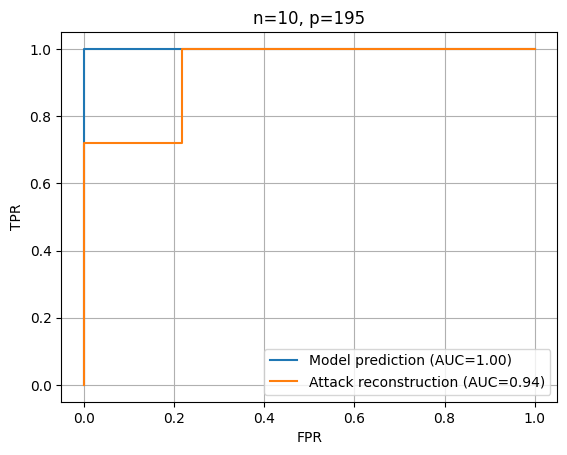

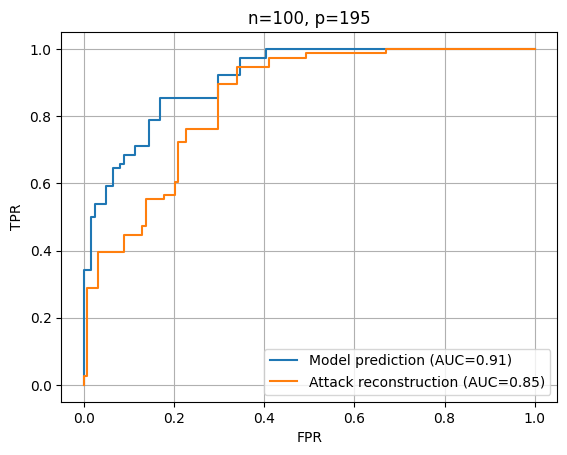

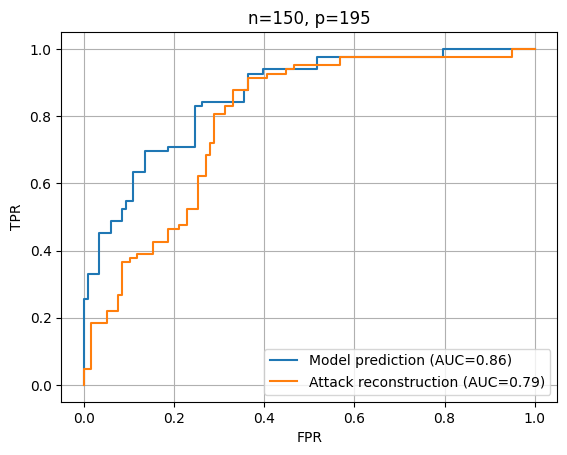

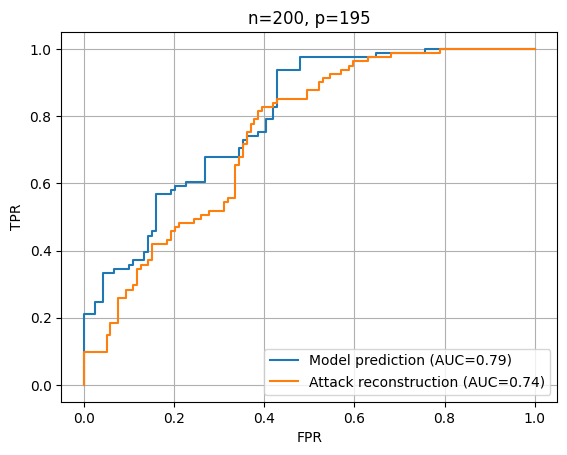

In [ ]:

def experiment_with_training_size(n_values):
    for n in n_values:
        # Split the data into training and testing sets with a fixed test size
        X_train, X_test, y_train, y_test = train_test_split(data, outcome, train_size=n, random_state=42)

        # Train a logistic regression model
        logreg = LogisticRegression()
        logreg.fit(X_train, y_train)

        # Compute predicted probabilities on the training data
        p_hat = logreg.predict_proba(X_train)[:, 1]

        # Calculate gradients for each sample
        grads = logreg_gradients(X_train, y_train, logreg)

        # Run the attack for this training size
        y_true = np.zeros(nMC)
        y_pred = np.zeros(nMC)
        y_guess = np.zeros(nMC)

        for i in range(nMC):
            ind = np.random.permutation(len(X_train))
            y_true[i] = y_train[ind[0]]
            y_pred[i] = p_hat[ind[0]]

            known_grad = np.sum(grads[ind[1:p+1]], axis=0)

            g1 = X_train[ind[0]] * (p_hat[ind[0]] - 1)
            g0 = X_train[ind[0]] * p_hat[ind[0]]

            s1 = known_grad + g1
            s0 = known_grad + g0

            y_guess[i] = 0.5 * ((np.sum(np.square(s1))) - np.sum(np.square(s0)))

        # Plot ROC curves for each training size
        display_two_roc_curves_from_predictions(
            y_true, y_pred, 'Model prediction', y_true, y_guess, 'Attack reconstruction'
        )
        plt.title(f"n={n}, p={p}")
        plt.show()

# Define a range of training sizes to test
n_values = [10, 100, 150, 200]
experiment_with_training_size(n_values)


We can see that the higher n is the less sucessful the attack is and with very few points it has a very high AUC.

# Differential Privacy for ML Course - Lab #2

*Master IASD, PSL - O. Cappé, January 2025*

This second lab is devoted to the use of the basic DP mechanism seen in the couse.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

## The Dataset

For this lab, we will use the UCI Indian Liver Patient Records Data Set. The dataset consists of liver patient records collected from Andhra Pradesh, India. You can read more about the dataset [here](https://archive.ics.uci.edu/dataset/225/ilpd+indian+liver+patient+dataset)). We will begin by loading the data from [OpenML](https://www.openml.org/) using `fetch_openml` method of `sklearn`.

In [2]:
openml = False
if (openml):
    data = fetch_openml(name='Indian-Liver-Patient-Records', version=2, as_frame=True).frame    # Load dataset from OpenML as a Pandas data rrame
else:
    # Backup solution, reading from a local CSV file
    data = pd.read_csv('/content/lab2_indian-liver.csv')
data.head(10)     # Print the first 10 rows of the dataset

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Proteins,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.9,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.0,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.4,1
5,46,Male,1.8,0.7,208,19,14,7.6,4.4,1.3,1
6,26,Female,0.9,0.2,154,16,12,7.0,3.5,1.0,1
7,29,Female,0.9,0.3,202,14,11,6.7,3.6,1.1,1
8,17,Male,0.9,0.3,202,22,19,7.4,4.1,1.2,2
9,55,Male,0.7,0.2,290,53,58,6.8,3.4,1.0,1


## Counting Query

This is a preparatory question in which we will go through the implementation of the Laplace mechanism for a simple counting query. The query should return the number of females in the dataset. You will use the `Gender` attribute in the dataset for this task. The code and plots done for this question will serve as the model for you for answering the rest of the questions.

We will use the variable `count` to store the non-private count of females in the dataset.

In [3]:
count = sum(data['Gender'] == 'Female')
print(count)

142


In the following code block, the function `countLap` implements the Laplace mechanism to return the count of the number of females. **Why is this $\epsilon$-DP?**

This is ϵ-DP because noise drawn from the Laplace distribution is added to the data to mask individual contribution.

In [4]:
def countLap(count, eps):
    """
    Adds Laplace noise to a given count for differential privacy.

    Parameters:
    count (int or float): The original count.
    eps (float): The privacy parameter epsilon.

    Returns:
    float: The count with added Laplace noise.
    """
    return count + np.random.laplace(0, 1/eps)

We can visualize the output of the `countLap` method by running the method several times and plotting the histogram of the returned counts.

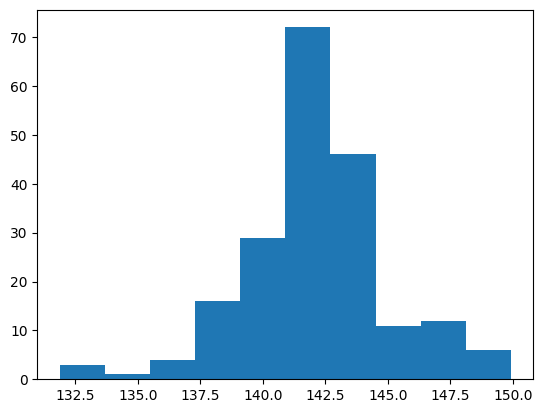

In [5]:
eps = 0.5           # The epsilon value for epsilon-DP
num_iter = 200     # Number of Monte carlo runs of the countLap mechanism
counts = [countLap(count, eps) for i in range(num_iter)]  # Counts is a list of all the noisy counts returned by the countLap mechanism
plt.hist(counts)    # Plot the histogram of counts
plt.show()

In the following code block, we will illustrate more systematically the accuracy of the `countLap` method for a range of $\epsilon$'s.

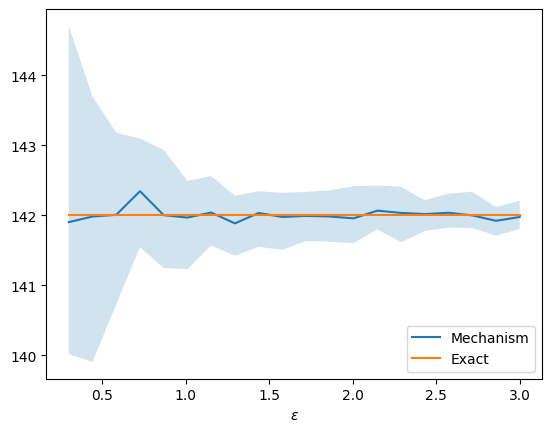

In [6]:
def accuracy_plot(mechanism, data, value):
    """
    Plots the accuracy of a given differential privacy mechanism over a range of epsilon values.
    Parameters:
    mechanism (function): The differential privacy mechanism to be evaluated. It should take two arguments: data and epsilon.
    value (float): The true value that is protected by the mechanism
    """
    num_iter = 100                                  # Number of Monte Carlo runs for each epsilon
    eps_arr = np.linspace(0.3, 3.0, num=20)         # Array of epsilons
    noisy_values_median = np.zeros_like(eps_arr)    # Array of median noisy values returned by the mechanism
    noisy_values_q1 = np.zeros_like(eps_arr)        # Array to store the first quartile of noisy values
    noisy_values_q3 = np.zeros_like(eps_arr)        # Array to store the third quartile of noisy values

    for i, eps in enumerate(eps_arr):
        values = [mechanism(data, eps) for i in range(num_iter)]
        noisy_values_median[i] = np.median(values)
        noisy_values_q1[i] = np.percentile(values, 25)
        noisy_values_q3[i] = np.percentile(values, 75)

    fig = plt.figure()
    plt.plot(eps_arr, noisy_values_median, label='Mechanism')
    plt.plot(eps_arr, value*np.ones_like(eps_arr), label='Exact')
    plt.fill_between(eps_arr, noisy_values_q1, noisy_values_q3, alpha = 0.2)
    plt.legend(loc="lower right")
    plt.xlabel("$\epsilon$")
    plt.show()

accuracy_plot(countLap, count, count)

#### Observations

- Notice that the smaller $\epsilon$ is, the greater is the "spread" or the standard deviation of the noisy counts of `countLap`
- Notice that the mean of the noisy counts returned by `countLap` roughly equals the Exact count. This is because the Laplace noise is mean zero. In other words, the output of `countLap` is an unbiased estimate of `count`.

# L1.1 Differentially Private Maximum

In this question and the following, we will consider the age feature for females. We know from the data documentation that this feature has been truncated at 90.

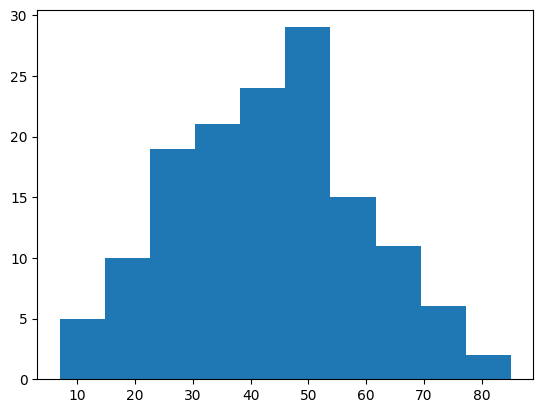

In [7]:
# Return an array with the ages of females
ages = np.array(data[data['Gender'] == 'Female']['Age'])
plt.hist(ages)
plt.show()

**Implement the Laplace mechanism for the maximum as a function and use the <code>accuracy_plot</code> function above to plot its accuracy. What do you think of the result and why is this happening?**

Return maximum edge what will the Laplace mechanism will look like. We want to add laplace noise, what is its value. The max edge has to be less than 90.

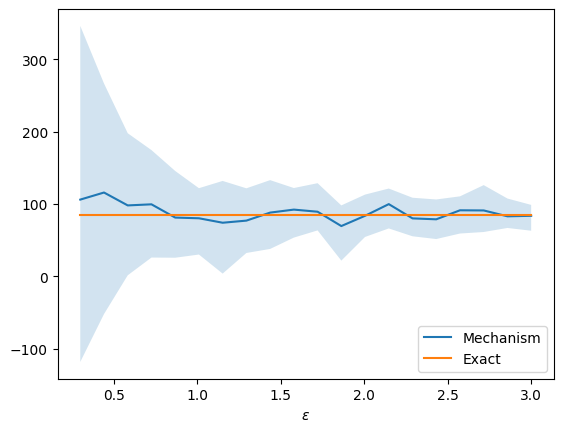

In [ ]:
def maxLap(ages, eps):
    """
    Computes the differentially private maximum of an array of ages using the Laplace mechanism.

    Parameters:
    ages (numpy.ndarray): An array of ages.
    eps (float): The privacy parameter epsilon, which controls the amount of noise added.

    Returns:
    float: The differentially private maximum of the ages array.
    """
    # TODO: Your code here
    #sensitivity of the max fn is 90  p.35 L2, scale 90/eps

    dp_max = np.max(ages) + np.random.laplace(0, 90/(eps))

    return dp_max



accuracy_plot(maxLap, ages, np.max(ages))

This introduces a large amount of noise which leads to a widely inacurate results, so while it protects privacy less accurate than the countLap for example. We can see that the variance is also more important.

Note that we could "improve" the result somewhat by truncating the output value between 0 and 90 for consistency (why is it possible to do so ?). trucate more in this intervale

We can also be less pessimistic about the range of values where we expect to find the maximum. For instance, show that the following mechanism is still $\epsilon$-DP.

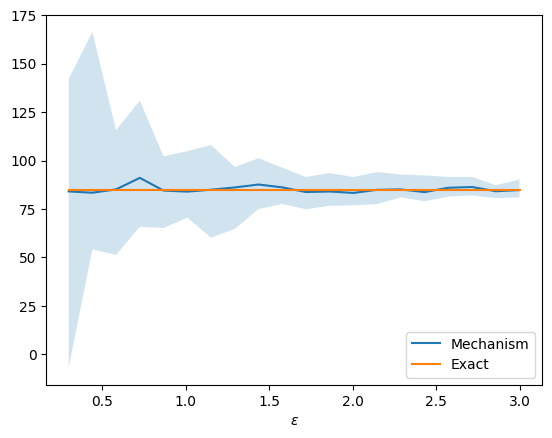

In [ ]:
def maxLap2(ages, eps):
    # Another mechanism to return the differentially private uncensored max age
    guess = 80
    split = 1/4
    n = sum(ages >= guess) + np.random.laplace(0, 1/(split*eps)) # counting query ages >90, split to split the privacy budget for n and dpmax
    if (n > 1):
        dpmax = max(guess, np.max(ages)) + np.random.laplace(0, (90-guess)/((1-split)*eps))#reduced sensitivity
    else:
        dpmax = np.max(ages) + np.random.laplace(0, 90/((1-split)*eps))
    return dpmax

accuracy_plot(maxLap2, ages, np.max(ages))

# 85 max age cant use it because gives information when reading the code output is better because smaller sensitivity, n should be epsilone DP

## L1.2 Differentially Private Arg Max

In this question, we will implement two mechanisms for reporting the id of the maximum of a feature. Specifically, we will implement algorithms that report the id of the most represented age categories among the females.

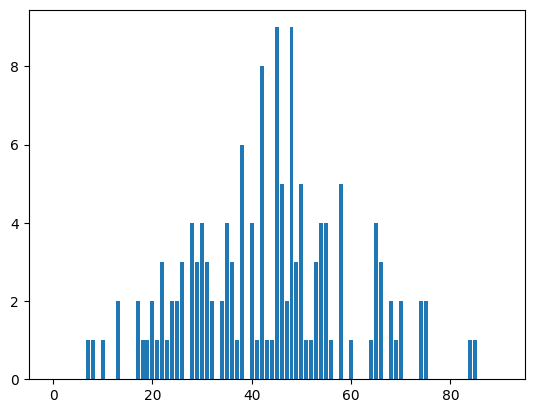

In [8]:
age_counts = np.array([np.sum(ages == i) for i in range(91)])
plt.bar(range(91), age_counts)
plt.show()

### L1.2.1 Noisy Max with Laplace Mechanism

**In the following code block, implement the `reportNoisyArgMax` function that implements the mechanism discussed in class that adds i.i.d. Laplace noise to the entries of the array and reports the index of the maximum in the noisy array.**

In [9]:
# Implement your mechanism here

def reportNoisyArgMax(x, eps):
    """
    Computes the noisy argmax of an array using Laplace noise.
    This function adds Laplace noise to each element of the input array `x`
    and returns the index of the maximum value in the noisy array.
    Parameters:
    x (array-like): The input array for which the noisy argmax is to be computed.
    eps (float): The privacy parameter epsilon.
    Returns:
    int: The index of the maximum value in the noisy array.
    """

    noisy_x = x + np.random.laplace(0, 1/eps, len(x)) # the sensitivity is one because it is a count-base query

    return np.argmax(noisy_x)


We can visualize the accuracy of the output of the `reportNoisyArgMax` method by running the mechanism several times and plotting the histogram of the ages corresponding to the returned indices.

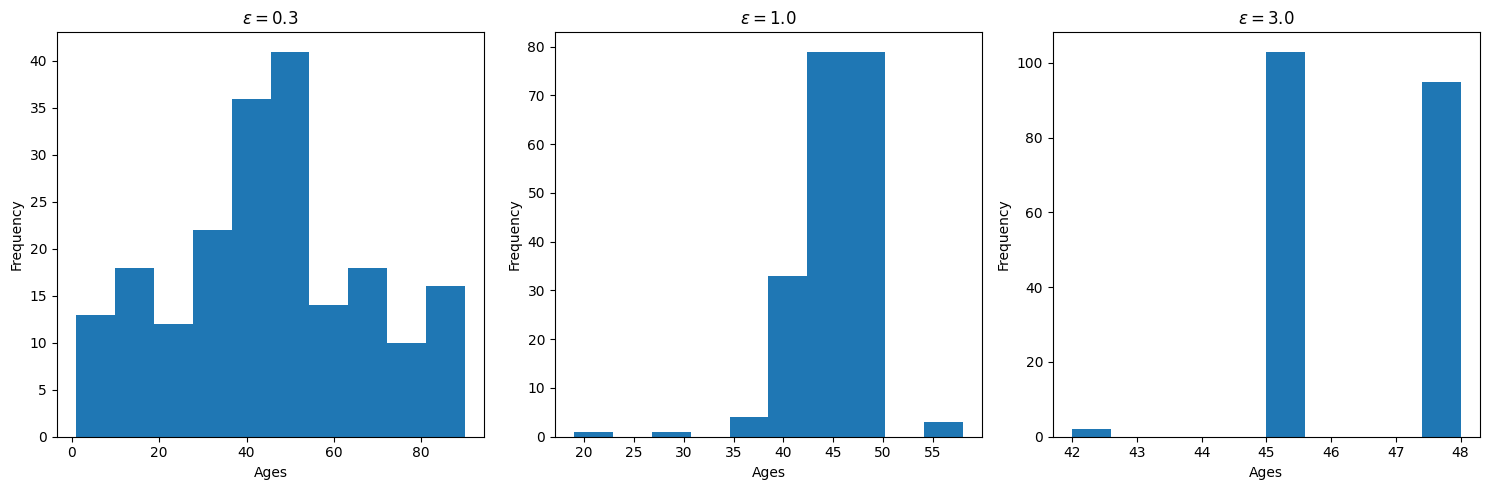

In [10]:
def accuracy_plot_for_argmax(mechanism, age_counts):
    eps_arr = np.array([0.3, 1, 3])
    num_iter = 200

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, eps in enumerate(eps_arr):
        age_ids = [mechanism(age_counts, eps) for _ in range(num_iter)]
        axs[i].hist(age_ids)
        axs[i].set_xlabel('Ages')
        axs[i].set_ylabel('Frequency')
        axs[i].set_title('$\epsilon = {}$'.format(eps))

    plt.tight_layout()
    plt.show()

accuracy_plot_for_argmax(reportNoisyArgMax, age_counts)

As we can see the higher epsilon is the less privacy we have.

### L1.2.2 Noisy Max with the Exponential Mechanism

We now consider addressing the same task using the Exponential mechanism. **What is the natural utility function $u(x,y)$ and what is its sensitivity?**

**Implement the exponential mechanism with the chosen utility function and illustrate the accuracy of the mechanism using the same plots as before.**

In [15]:
def argMaxExp(x,eps):

    # Compute probability distribution
    utility = age_counts
    probabilities = np.exp((eps * utility) / (2))
    probabilities /= np.sum(probabilities)

    # Sample an index based on probabilities
    return np.random.choice(len(utility), p=probabilities)


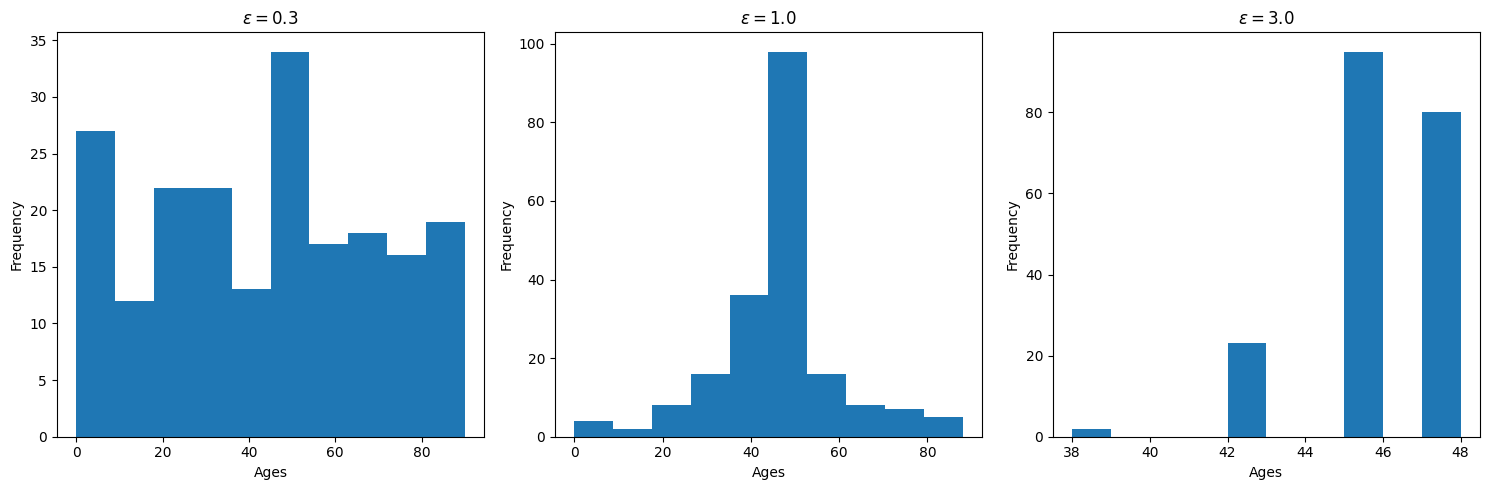

In [16]:
accuracy_plot_for_argmax(argMaxExp, age_counts)

# Differential Privacy for ML Course - Lab #3

*Master IASD, PSL - O. Cappé, February 2025*

This third lab is devoted to DP mechanisms for the linear regression model.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error
# Root mean squared error
def root_mean_squared_error(y, yhat):
    return np.sqrt(mean_squared_error(y, yhat))

## The Dataset

For this lab, we will use the sames dataset as in Lab #2.

In [ ]:
openml = False
if (openml):
    data = fetch_openml(name='Indian-Liver-Patient-Records', version=2, as_frame=True).frame    # Load dataset from OpenML as a Pandas data rrame
else:
    # Backup solution, reading from a local CSV file
    data = pd.read_csv('lab2_indian-liver.csv')
data.head(10)     # Print the first 10 rows of the dataset

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Proteins,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.9,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.0,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.4,1
5,46,Male,1.8,0.7,208,19,14,7.6,4.4,1.3,1
6,26,Female,0.9,0.2,154,16,12,7.0,3.5,1.0,1
7,29,Female,0.9,0.3,202,14,11,6.7,3.6,1.1,1
8,17,Male,0.9,0.3,202,22,19,7.4,4.1,1.2,2
9,55,Male,0.7,0.2,290,53,58,6.8,3.4,1.0,1


In [ ]:
data

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Proteins,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.9,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.0,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.4,1
...,...,...,...,...,...,...,...,...,...,...,...
578,60,Male,0.5,0.1,500,20,34,5.9,1.6,0.37,2
579,40,Male,0.6,0.1,98,35,31,6.0,3.2,1.1,1
580,52,Male,0.8,0.2,245,48,49,6.4,3.2,1.0,1
581,31,Male,1.3,0.5,184,29,32,6.8,3.4,1.0,1


## Linear Regression

We will consider simple (i.e., one-dimensional) linear regression with `Albumin` as the regressor $x$ and `Total_Proteins` as the target $y$. We will consider that the data can be approximately normalized by the following transform, making in possible to assume that all $x_i$ and $y_i$ are in $(-1,1)$.

In [ ]:
x = (np.array(data['Albumin']).reshape(-1, 1)-3)/3
y = (np.array(data['Total_Proteins']).reshape(-1, 1)-5)/5

## Linear Regression
Given $\{(x_i,y_i)\}_{i=1}^n$, the task is to find the parameters $(\beta_1, \beta_0)$ to fit the following linear model,
$y = \beta_1 x + \beta_0$.

Let $X$ denote the $n\times 2$ matrix whose first column is composed of $x_1, \ldots, x_n$ and second column composed of all ones. Let $\beta = [\beta_1 \ \beta_0]^T$. Recall that the ordinary least squares (OLS) solution to the problem is the following.

$$
\hat{\beta}_{OLS} = (X^TX)^{-1}X^Ty
=   \begin{bmatrix}
    \sum_i x_i^2 & \sum_i x_i\\
    \sum_i x_i & n
    \end{bmatrix}^{-1}
    \begin{bmatrix}
    \sum_i x_iy_i\\
    \sum_i y_i
    \end{bmatrix}
$$.


### Linear Regression with OLS

The following code block implements the function `linreg` that computes $\beta$ using the OLS formula above.

In [ ]:
def linreg(x,y):
    """
    Performs linear regression using Ordinary Least Squares (OLS).
    Parameters:
    x (numpy.ndarray): A 1D array of input features.
    y (numpy.ndarray): A 1D array of target values.
    Returns:
    numpy.ndarray: A 1D array containing the coefficients (slope, intercept) of the linear regression model.
    """

    n = x.size

    # Compute statistics
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xy = np.matmul(x.T, y).item()
    sum_x2 = np.matmul(x.T, x).item()

    # Solve the normal equations
    xTx = np.array([[sum_x2, sum_x], [sum_x, n]])
    xTy = np.array([[sum_xy], [sum_y]])
    beta_ols = np.linalg.solve(xTx, xTy)

    return beta_ols

The following code blocks illustrate the result of the `linreg` function applied to the data.

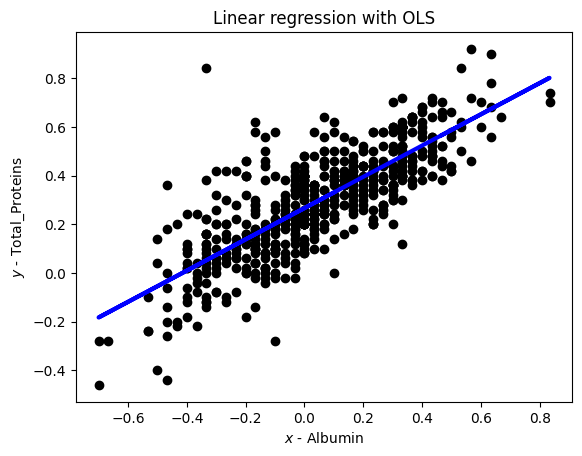

In [ ]:
def plot_linreg(x, y, beta, title):
    yhat = beta[0]*x + beta[1]
    plt.scatter(x, y,  color='black')
    plt.plot(x, yhat, color='blue', linewidth=3)
    plt.xlabel(r'$x$ - Albumin')
    plt.ylabel(r'$y$ - Total_Proteins')
    plt.title(title)
    plt.show()

beta = linreg(x,y)
plot_linreg(x, y, beta,'Linear regression with OLS')

### L3.1 Perturbed Least Squares with Gaussian Mechanism

Given that the OLS solution is a function of the four statistics $\sum_i x_i^2, \sum_i x_i, \sum_i x_i y_i$ and $\sum_i y_i$, we will first consider using the Gaussian mechanism to perturb these statistics. **How should the scale of the Gaussian noise $\sigma$ be set so as to achieve $(\epsilon,\delta)$-DP with $\delta = 1/n$? Implement as `dp_linreg_pertub` a variant of  the `linreg`function above that implements this mechanism.**

dont add noise to n and only once to sum of xi. sensitivity of each xi xiyi and then multiply by scale, and square root of number of stat.

L2 sensitivity: Δ= max change xi,y to xi',yi =|| (xi²,xi,xiy, y)-(xi²',xi',xi'y', y')||

each of this var are bteween -1 and 1 max in dimension 4--> difficult to solve

Solution: evaluate sensitivity of each coordinate (xi²,xi,xiy, y)-(xi²',xi',xi'y', y') diff between two positive numb less than one. Δ1 = 1, Δ2 = 2, Δ3 = 2, Δ4 = 2

add noise Δ = square-root 3.2² +1

= 2 sqr 3.5 --> L2 norm use it as the multiplier for the scale of the gaussian distribution

fixe delta 1/583






**Classical Result  [Theorem 3.22 of Dwork & Roth, 2014]** If $ \varepsilon \leq 1$, $(\epsilon,\delta)$-DP if
$$ \sigma \geq \frac{\Delta}{\varepsilon} \sqrt{2 \log(1.25 / \delta)} $$

But we use the alternative where we assume that $\varepsilon \leq 1$, this yields $\sigma_{\min} = \sqrt{2\log(e/\delta)/\varepsilon}$, which is the Dwork & Roth formula with a slightly bigger constant in the log. A more natural result is obtained when assuming only $\varepsilon \leq \log(1/ \delta)$, which is the "usual" regime:
$$
\sigma_{\min} = \frac{\sqrt{2}+2}{2} \frac{\sqrt{\log(1/\delta)}}{\varepsilon} \leq \frac{\sqrt{2.92\log(1/\delta)}}{\varepsilon}
$$

Since we have $x_i$ ∈ [-1;1] and $y_i$ ∈ [-1;1].

$$
\text{grad}_0 = -\frac{2}{n} \sum_{i=1}^{n} (y_i - (\beta^0 x_i + \beta^1)) x_i
$$

$$
\text{grad}_1 = -\frac{2}{n} \sum_{i=1}^{n} (y_i - (\beta^0 x_i + \beta^1))
$$

$Δ_2 = \frac{4}{n}$




In [ ]:
def dp_linreg_perturb(x, y, eps):
    """
    Performs (eps,1/n)-DP linear regression using Gauss Perturbed Least Squares.

    Parameters:
    x (numpy.ndarray): A 1D array of input features.
    y (numpy.ndarray): A 1D array of target values.
    eps (float): Privacy budget

    Returns:
    numpy.ndarray: A 1D array containing the coefficients (slope, intercept) of the linear regression model.
    """
    n = x.size
    delta = 1 / n  # Given delta = 1/n
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xy = np.matmul(x.T, y).item()
    sum_x2 = np.matmul(x.T, x).item()

    # Compute global L2 sensitivity
    sensitivity = np.sqrt(13)

    # Compute noise scale
    sigma = 1.71 * np.sqrt(np.log(1 / delta)) / eps

    # Add Gaussian noise
    sum_x2_noisy = sum_x2 + np.random.normal(0, sigma)
    sum_x_noisy = sum_x + np.random.normal(0, sigma)
    sum_xy_noisy = sum_xy + np.random.normal(0, sigma)
    sum_y_noisy = sum_y + np.random.normal(0, sigma)

    # Solve normal equations using noisy statistics
    xTx_noisy = np.array([[sum_x2_noisy, sum_x_noisy], [sum_x_noisy, n]])
    xTy_noisy = np.array([[sum_xy_noisy], [sum_y_noisy]])

    # Compute DP coefficients
    beta_gauss = np.linalg.solve(xTx_noisy, xTy_noisy)

    return beta_gauss

In the following code block, test the `dp_linreg_pertub` and compare its output with ordinary least squares.

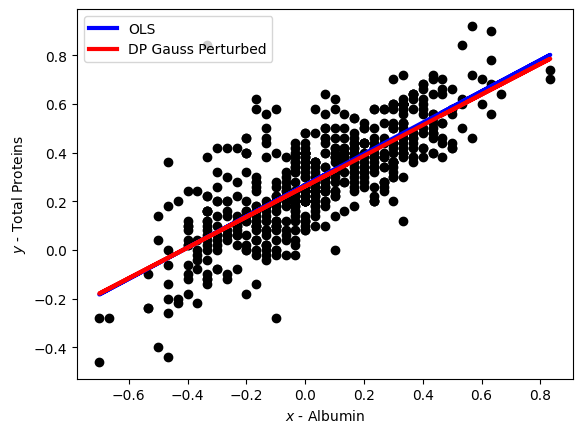

In [ ]:
def plot_compar_linreg(x, y, beta1, title1, beta2, title2):
    yhat1 = beta1[0]*x + beta1[1]
    yhat2 = beta2[0]*x + beta2[1]

    plt.scatter(x, y,  color='black')
    plt.plot(x, yhat1, color='blue', linewidth=3, label=title1)
    plt.plot(x, yhat2, color='red', linewidth=3, label=title2)
    plt.legend(loc="upper left")
    plt.xlabel(r'$x$ - Albumin')
    plt.ylabel(r'$y$ - Total Proteins')
    plt.show()

eps = 3
plot_compar_linreg(x, y, linreg(x,y), 'OLS', dp_linreg_perturb(x, y, eps), 'DP Gauss Perturbed')

To measure the accuracy of the mechanism, we compute the median root mean squared error (RMSE) over multiple runs of the mechanism.

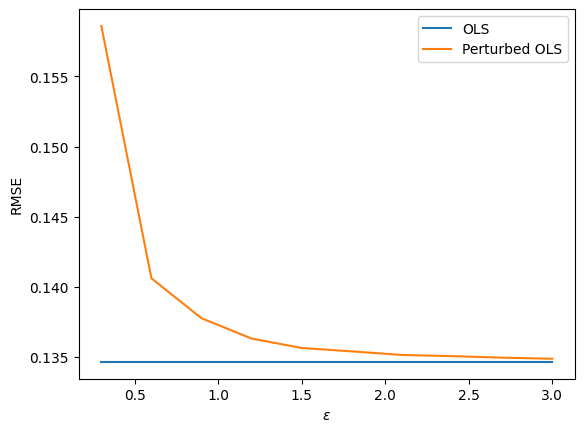

In [ ]:
num_iter = 1000
eps_arr = np.linspace(0.3, 3, num=10)

beta_ols = linreg(x,y)
yhat_ols = beta_ols[0]*x + beta_ols[1]
rmse_ols = root_mean_squared_error(y, yhat_ols)*np.ones_like(eps_arr)
rmse = np.zeros((eps_arr.size, num_iter))

for i, eps in enumerate(eps_arr):
    for j in range(num_iter):
        beta = dp_linreg_perturb(x, y, eps)
        yhat = beta[0]*x + beta[1]
        rmse[i][j] = root_mean_squared_error(y, yhat)

fig = plt.figure()
plt.plot(eps_arr, rmse_ols, label='OLS')
plt.plot(eps_arr, np.median(rmse, axis=1), label='Perturbed OLS')
plt.legend(loc="upper right")
plt.xlabel("$\epsilon$")
plt.ylabel("RMSE")
plt.show()

### L3.2 Perturbed Gradient Descent

#### Gradient Descent

For this question, we will estimate $\hat{\beta}$ using gradient descent. Recall that in gradient descent, we start from an arbitraty initialization $\hat{\beta}_0$ for $\hat{\beta}$ and update $\hat{\beta}$ using the following equation.

$\hat{\beta}_{t+1} = \hat{\beta}_t - \gamma \nabla L(\hat{\beta}_t)$,

where $t$ is the iteration number running from $1$ to $T$ (maximum number of gradient steps), $\alpha$ is the step-size and $\nabla L(\hat{\beta}_t)$ is the gradient of the loss

$L(\beta) = \frac{1}{n} \sum_{i=1}^n (y_i - (\beta_0 x + \beta_1))^2$

evaluated at $\hat{\beta}_t$.

The following code block, implements the function `linreg_gd` that computes $\beta$ using gradient descent. Note that `linreg_gd` returns a list of $\hat{\beta}_t$ for each step $t$ of the gradient descent.

In [ ]:
def linreg_gd(x, y, step_size, num_steps):
    '''
    Performs linear regression using gradient descent.
    Parameters:
    x (array of shape (n, 1)): Regressor
    y (array of shape (n, 1)): Target
    step_size (positive float): Step size for gradient descent
    num_steps (positive int (positive): Number of gradient descent steps
    Returns
    beta_list : list of length num_steps, where each element is an array of shape (2, 1)
        beta_list[t] is the estimate beta at step t
        beta_list[t][0] is the slope
        beta_list[t][1] is the y-intercept
    '''
# perturbate the gradient, dont care about step size
    n = y.size
    beta = np.zeros((2,1))
    beta_list = [beta]

    for i in range(num_steps):
        yhat = beta[0]*x + beta[1]
        grad = np.zeros_like(beta)
        grad[0] = -2*np.mean((y - yhat)*x) # bond the sensitivity of the gradient, number of iteration has an impact
        grad[1] = -2*np.mean(y - yhat)#
        beta = beta - step_size*grad
        beta_list.append(beta)

    return beta_list

compute gradient : taylor expension of first order for beta

The following code block illustrates the convergence of gradient descent.

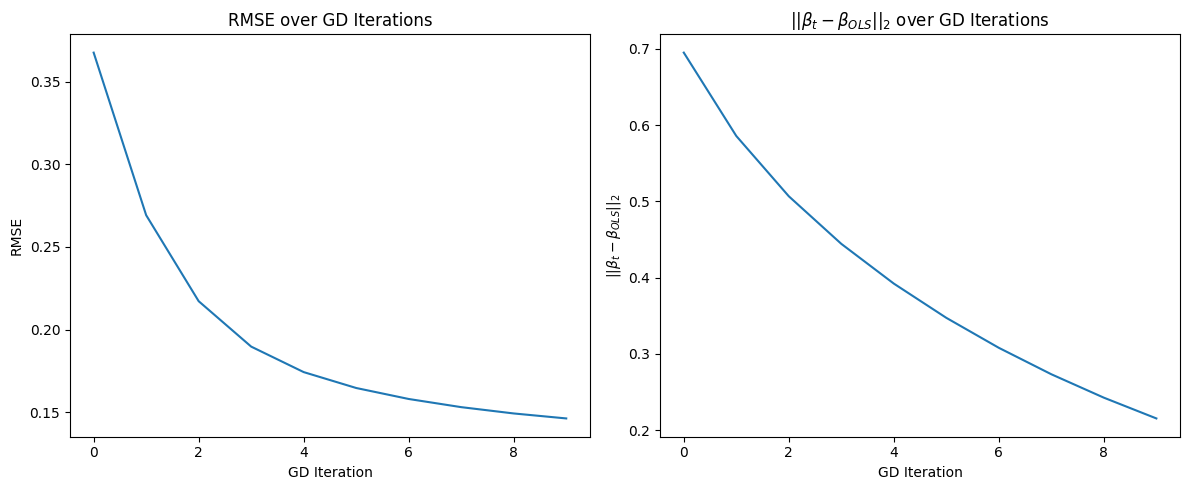

In [ ]:
num_steps = 10
step_size = 0.8

beta_ols = linreg(x, y)
beta_gd = linreg_gd(x, y, step_size, num_steps)

rmse_gd = np.zeros(num_steps)
err_beta_gd = np.zeros(num_steps)

for i in range(num_steps):
    yhat = beta_gd[i][0]*x + beta_gd[i][1]
    rmse_gd[i] = root_mean_squared_error(y, yhat)
    err_beta_gd[i] = np.linalg.norm(beta_gd[i] - beta_ols)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(rmse_gd)
ax1.set_xlabel('GD Iteration')
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE over GD Iterations')

ax2.plot(err_beta_gd)
ax2.set_xlabel('GD Iteration')
ax2.set_ylabel(r'$||\beta_t - \beta_{OLS}||_2$')
ax2.set_title(r'$||\beta_t - \beta_{OLS}||_2$ over GD Iterations')

plt.tight_layout()
plt.show()

#### Q2.4 Differentially Private Gradient Descent (DP-GD)




For this question we will assume that $\hat{\beta}_0, \hat{\beta}_1 \in [-1,1]$. **Bound the $L^2$ sensitivity of the gradient under this assumption and write a function `dp_linreg_gd`(following the code of `linreg_gd`) with adds Gaussian perturbation to each gradient update and is globally $(\epsilon,\delta)$-DP with $\delta=1/n$. You should justify the sensitivity computation as well as the use of the DP budget.**

In [ ]:
def dp_linreg_gd(x,y, step_size, num_steps, eps):
    '''
    Performs (eps,1/n)-DP linear regression using Gauss Perturbed Gradient Descent.
    Parameters:
    x (array of shape (n, 1)): Regressor
    y (array of shape (n, 1)): Target
    step_size (positive float): Step size for gradient descent
    num_steps (positive int (positive): Number of gradient descent steps
    eps (positive float): Privacy budget
    Returns:
    beta_list : list of length num_steps, where each element is an array of shape (2, 1)
    '''

    # TODO: Implement (eps,1/n)-DP linear regression using Gauss Perturbed Gradient Descent
    n = y.size
    beta = np.zeros((2,1))
    beta_list = [beta]
    delta = 1/n
    sensitivity = 4 / n  # Sensitivity of gradient
    sigma = (sensitivity * np.sqrt( 2.92 *np.log(1 / delta)) / eps) * np.sqrt(num_steps)


    for i in range(num_steps):
        yhat = beta[0]*x + beta[1]
        grad = np.zeros_like(beta)
        grad[0] = -2*np.mean((y - yhat)*x) # bond the sensitivity of the gradient, number of iteration has an impact
        grad[1] = -2*np.mean(y - yhat)#

        noise = np.random.normal(0, sigma, size=grad.shape)
        grad += noise

        beta = beta - step_size * grad
        beta_list.append(beta)

    return beta_list

The following code block, test the `dp_linreg` function and plots the convergence of the sequence of linear regression parameter estimates. **You should run it a few times to get an idea of the variability**.

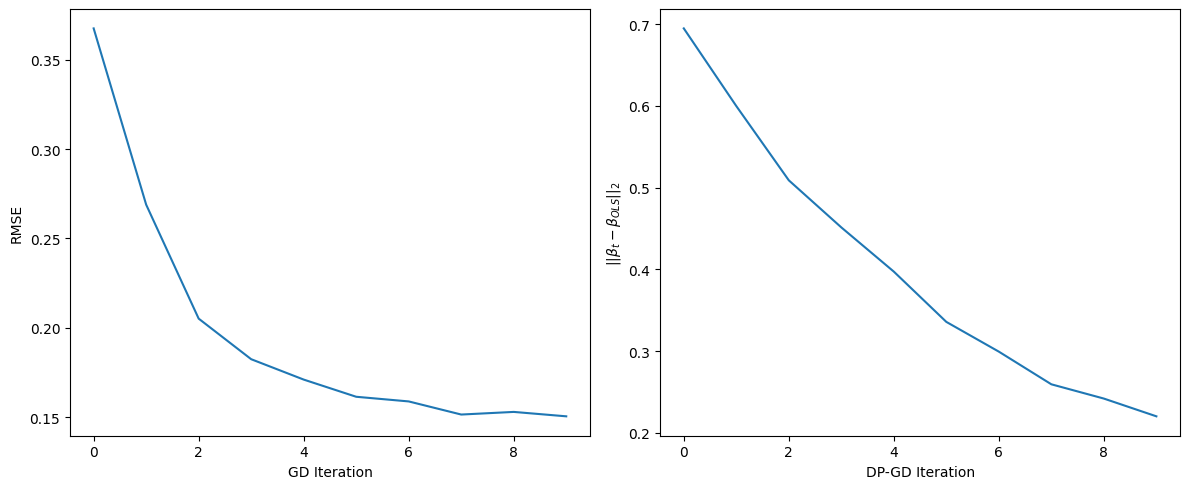

In [ ]:
eps = 5

beta_list_dpgd = dp_linreg_gd(x, y, step_size, num_steps, eps)
rmse_dpgd = np.zeros(num_steps)
err_beta_dpgd = np.zeros(num_steps)
for i in range(num_steps):
    yhat = beta_list_dpgd[i][0]*x + beta_list_dpgd[i][1]
    rmse_dpgd[i] = root_mean_squared_error(y, yhat)
    err_beta_dpgd[i] = np.linalg.norm(beta_list_dpgd[i] - beta_ols)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(rmse_dpgd)
ax1.set_xlabel('GD Iteration')
ax1.set_ylabel('RMSE')

ax2.plot(err_beta_dpgd)
ax2.set_xlabel('DP-GD Iteration')
ax2.set_ylabel(r'$||\beta_t - \beta_{OLS}||_2$')

plt.tight_layout()
plt.show()

The following code block, plots the median RMSE performance of the `dp_linreg_gd` comparing it to the (non private) values achieved by `linreg` and `lingreg_gd`.

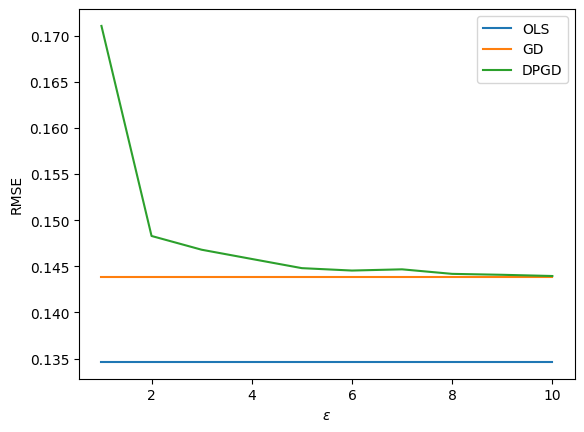

In [ ]:
beta_ols = linreg(x, y)
yhat_ols = beta_ols[0]*x + beta_ols[1]
rmse_ols = root_mean_squared_error(y, yhat_ols)*np.ones_like(eps_arr)

beta_gd = linreg_gd(x, y, step_size, num_steps)[-1]
yhat_gd = beta_gd[0]*x + beta_gd[1]
rmse_gd = root_mean_squared_error(y, yhat_gd)*np.ones_like(eps_arr)

num_iter = 100
eps_arr = np.linspace(1, 10, num=10)
rmse_dpgd = np.zeros((eps_arr.size, num_iter))

for i, eps in enumerate(eps_arr):
    for j in range(num_iter):
        beta_dpgd = dp_linreg_gd(x, y, step_size, num_steps, eps)[-1]
        yhat_dpgd = beta_dpgd[0]*x + beta_dpgd[1]
        rmse_dpgd[i][j] = root_mean_squared_error(y, yhat_dpgd)

fig = plt.figure()
plt.plot(eps_arr, rmse_ols, label='OLS')
plt.plot(eps_arr, rmse_gd, label='GD')
plt.plot(eps_arr, np.median(rmse_dpgd, axis=1), label='DPGD')
plt.legend(loc="upper right")
plt.xlabel("$\epsilon$")
plt.ylabel("RMSE")
plt.show()










Even in this simplistic example, it turns out that the maximal $L^2$ sensitivity bound that can be obtained for the gradient from our assumptions is rather pessimistic. **Modify the `dp_lingreg_gd` code so as to be able to experiment with the gradient norm-clipping alternative used in DP-SGD. Can you find a value of the clipping which provides an improved accuracy?**

**Due to the addition of noise to the gradient at each step, it is not necessarily the case that using the same constant step size scheme and number of iterations leads to optimal results in terms of accuracy. Can you come up with a better solution while keeping the same $(\epsilon,\delta=1/n)$ DP budget (say, for a typical value of $\epsilon=3$)?**

In [ ]:
import numpy as np

def linreg_gd_grad(x, y, step_size, num_steps):
    n = y.size
    beta = np.zeros((2,1))
    grad_norms = []  # Store L2 norms of gradients

    for i in range(num_steps):
        yhat = beta[0] * x + beta[1]
        grad = np.zeros_like(beta)
        grad[0] = -2 * np.mean((y - yhat) * x)
        grad[1] = -2 * np.mean(y - yhat)

        # Compute and store the L2 norm of the gradient
        grad_norm = np.linalg.norm(grad, ord=2)
        grad_norms.append(grad_norm)

        beta = beta - step_size * grad

    return grad_norms


In [ ]:
grad_norms = linreg_gd(x, y, step_size=0.8, num_steps=100)

# Select clip_norm as the 90th percentile of gradient norms
clip_norm = np.percentile(grad_norms, 90)
print(f"Recommended clip_norm: {clip_norm:.3f}")

Recommended clip_norm: 0.642


In [ ]:
import numpy as np

def dp_linreg_gd_clip(x, y, step_size, num_steps, eps, clip_norm=0.642):
    '''
    Performs (eps,1/n)-DP linear regression using Gaussian Perturbed Gradient Descent with Clipping.

    Parameters:
    x (array of shape (n, 1)): Regressor
    y (array of shape (n, 1)): Target
    step_size (float): Initial step size for gradient descent
    num_steps (int): Number of gradient descent steps
    eps (float): Privacy budget
    clip_norm (float): Clipping norm for gradients (default = 1.0)

    Returns:
    beta_list : list of length num_steps, where each element is an array of shape (2, 1)
    '''

    n = y.size
    beta = np.zeros((2,1))
    beta_list = [beta]
    delta = 1 / n
    sensitivity = clip_norm / n

    # Compute noise scale for DP guarantee
    sigma = (sensitivity * np.sqrt(2.92 * np.log(1 / delta)) / eps) * np.sqrt(num_steps)

    for i in range(num_steps):
        yhat = beta[0] * x + beta[1]

        # Compute gradient
        grad = np.zeros_like(beta)
        grad[0] = -2 * np.mean((y - yhat) * x)
        grad[1] = -2 * np.mean(y - yhat)

        grad_norm = np.linalg.norm(grad, ord=2)
        if grad_norm > clip_norm:
            grad = (clip_norm / grad_norm) * grad

        # Add Gaussian noise
        noise = np.random.normal(0, sigma)
        grad += noise

        # Gradient descent update
        beta = beta - step_size * grad
        beta_list.append(beta)

    return beta_list


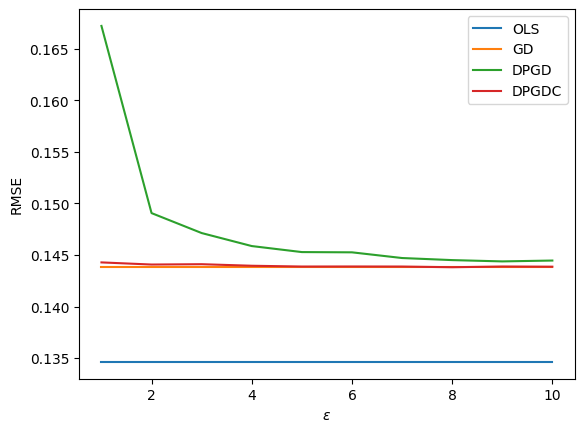

In [ ]:
beta_ols = linreg(x, y)
yhat_ols = beta_ols[0]*x + beta_ols[1]
rmse_ols = root_mean_squared_error(y, yhat_ols)*np.ones_like(eps_arr)

beta_gd = linreg_gd(x, y, step_size, num_steps)[-1]
yhat_gd = beta_gd[0]*x + beta_gd[1]
rmse_gd = root_mean_squared_error(y, yhat_gd)*np.ones_like(eps_arr)

num_iter = 100
eps_arr = np.linspace(1, 10, num=10)
rmse_dpgd = np.zeros((eps_arr.size, num_iter))
rmse_cdpgd = np.zeros((eps_arr.size, num_iter))

for i, eps in enumerate(eps_arr):
    for j in range(num_iter):
        beta_dpgd = dp_linreg_gd(x, y, step_size, num_steps, eps)[-1]
        yhat_dpgd = beta_dpgd[0]*x + beta_dpgd[1]
        rmse_dpgd[i][j] = root_mean_squared_error(y, yhat_dpgd)
        beta_cdpgd = dp_linreg_gd_clip(x, y, step_size, num_steps, eps)[-1]
        yhat_cdpgd = beta_cdpgd[0]*x + beta_cdpgd[1]
        rmse_cdpgd[i][j] = root_mean_squared_error(y, yhat_cdpgd)

fig = plt.figure()
plt.plot(eps_arr, rmse_ols, label='OLS')
plt.plot(eps_arr, rmse_gd, label='GD')
plt.plot(eps_arr, np.median(rmse_dpgd, axis=1), label='DPGD')
plt.plot(eps_arr, np.median(rmse_cdpgd, axis=1), label='DPGDC')
plt.legend(loc="upper right")
plt.xlabel("$\epsilon$")
plt.ylabel("RMSE")
plt.show()

We can see that when we clip we get much better results than without. For example with a privacy budget of ϵ = 3, we get similar results than gradient descent and much better results than DP-Gradient Descent.

In [75]:

def step_dp_linreg_gd(x, y, step_size, num_steps, eps):
    '''
    Performs (eps,1/n)-DP linear regression using Gauss Perturbed Gradient Descent with adaptive step size.

    Parameters:
    x (array of shape (n, 1)): Regressor
    y (array of shape (n, 1)): Target
    step_size (positive float): Initial step size for gradient descent
    num_steps (positive int): Number of gradient descent steps
    eps (positive float): Privacy budget

    Returns:
    beta_list : list of length num_steps, where each element is an array of shape (2, 1)
    '''

    n = y.size
    beta = np.zeros((2, 1))
    beta_list = [beta]
    delta = 1/n
    sensitivity = 4 / n  # Sensitivity of gradient
    sigma = (sensitivity * np.sqrt(2.92 * np.log(1 / delta)) / eps) * np.sqrt(num_steps)

    for t in range(1, num_steps + 1):
        yhat = beta[0] * x + beta[1]
        grad = np.zeros_like(beta)
        grad[0] = -2 * np.mean((y - yhat) * x)
        grad[1] = -2 * np.mean(y - yhat)

        noise = np.random.normal(0, sigma, size=grad.shape)
        grad += noise

        # Adaptive step size: decrease over time
        eta_t = step_size / (1+0.001 * t)  # Slower decay

        beta = beta - eta_t * grad
        beta_list.append(beta)

    return beta_list


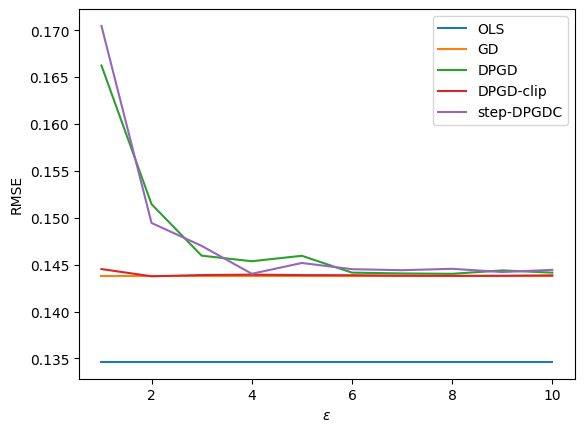

In [77]:
beta_ols = linreg(x, y)
yhat_ols = beta_ols[0]*x + beta_ols[1]
rmse_ols = root_mean_squared_error(y, yhat_ols)*np.ones_like(eps_arr)

beta_gd = linreg_gd(x, y, step_size, num_steps)[-1]
yhat_gd = beta_gd[0]*x + beta_gd[1]
rmse_gd = root_mean_squared_error(y, yhat_gd)*np.ones_like(eps_arr)

num_iter = 100
eps_arr = np.linspace(1, 10, num=10)
rmse_dpgd = np.zeros((eps_arr.size, num_iter))
rmse_cdpgd = np.zeros((eps_arr.size, num_iter))
rmse_step_dpgd = np.zeros((eps_arr.size, num_iter))

for i, eps in enumerate(eps_arr):
    for j in range(num_iter):
        beta_dpgd = dp_linreg_gd(x, y, step_size, num_steps, eps)[-1]
        yhat_dpgd = beta_dpgd[0]*x + beta_dpgd[1]
        rmse_dpgd[i][j] = root_mean_squared_error(y, yhat_dpgd)
        beta_cdpgd = dp_linreg_gd_clip(x, y, step_size, num_steps, eps)[-1]
        yhat_cdpgd = beta_cdpgd[0]*x + beta_cdpgd[1]
        rmse_cdpgd[i][j] = root_mean_squared_error(y, yhat_cdpgd)
        beta_step_dpgd = step_dp_linreg_gd(x, y, step_size, num_steps, eps)[-1]
        yhat_step_dpgd = beta_step_dpgd[0]*x + beta_step_dpgd[1]
        rmse_step_dpgd[i][j] = root_mean_squared_error(y, yhat_step_dpgd)

fig = plt.figure()
plt.plot(eps_arr, rmse_ols, label='OLS')
plt.plot(eps_arr, rmse_gd, label='GD')
plt.plot(eps_arr, np.median(rmse_dpgd, axis=1), label='DPGD')
plt.plot(eps_arr, np.median(rmse_cdpgd, axis=1), label='DPGD-clip')
plt.plot(eps_arr, np.median(rmse_step_dpgd, axis=1), label='step-DPGDC')
plt.legend(loc="upper right")
plt.xlabel("$\epsilon$")
plt.ylabel("RMSE")
plt.show()

We can see that when modifying the step-size and reducing it we get similar results than the DPGP.